In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import itertools

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 1. Data exploration and processing

In [4]:
results = pd.read_csv('../Datasets/womens-international-results-master/results.csv', encoding='latin-1')

In [5]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country/area,neutral
0,11/1/1969,Italy,France,1,0,Euro,Novara,Italy,False
1,11/1/1969,Denmark,England,4,3,Euro,Aosta,Italy,True
2,11/2/1969,England,France,2,0,Euro,Turin,Italy,True
3,11/2/1969,Italy,Denmark,3,1,Euro,Turin,Italy,False
4,8/25/1975,Thailand,Australia,3,2,AFC Championship,Hong Kong,Hong Kong,True


In [6]:
results.shape

(4884, 9)

In [7]:
#there is no missing data in the dataset
results.isna().sum()

date            0
home_team       0
away_team       0
home_score      0
away_score      0
tournament      0
city            0
country/area    0
neutral         0
dtype: int64

In [8]:
results.dtypes

date            object
home_team       object
away_team       object
home_score       int64
away_score       int64
tournament      object
city            object
country/area    object
neutral           bool
dtype: object

In [9]:
#transform 'date' column to integer which shows only the year
results['date'] = pd.to_datetime(results['date'])
results['date_Y'] = results['date'].dt.to_period('Y')
results['date_Y'] = results['date_Y'].astype('str').astype('int')

<Axes: >

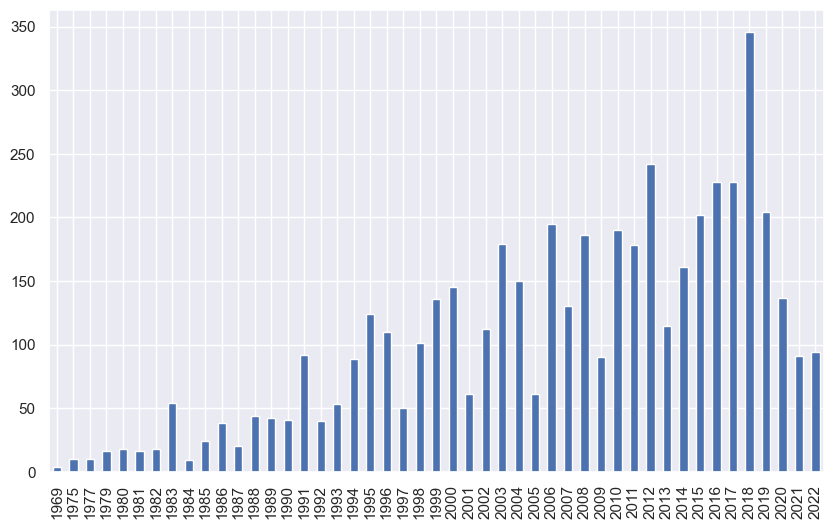

In [10]:
#game year ranges from 1969 to 2022, with more games in dataset during later years.
results['date_Y'].value_counts().sort_index().plot(kind = 'bar', figsize = (10,6))

In [11]:
#generate a set of all countries and count the total number
country_set = set(results['home_team'])|set(results['away_team'])

In [12]:
len(country_set)

203

In [13]:
#bring in the list of all countries qualified for WC2023 group stage
qualified_list = ['New Zealand', 'Norway', 'Philippines', 'Switzerland','Australia', 'Republic of Ireland', 'Nigeria', 'Canada',
                  'Spain', 'Costa Rica', 'Zambia', 'Japan','England', 'Haiti', 'Denmark', 'China PR','United States', 
                  'Vietnam', 'Netherlands', 'Portugal','France', 'Jamaica', 'Brazil', 'Panama','Sweden', 'South Africa', 
                  'Italy', 'Argentina','Germany', 'Morocco', 'Colombia', 'South Korea']

In [14]:
missing = []

In [15]:
#check if any qualified country was not in the dataset
for country in qualified_list:
    if country in country_set:
        pass
    else:
        missing.append(country)

In [16]:
missing

[]

In [17]:
#check the frequency of each qualified country in the dataset
qualified_frequency = pd.DataFrame()
qualified_frequency['Country'] = qualified_list
qualified_frequency['Frequency'] = qualified_frequency['Country'].apply(
    lambda x: results['home_team'].value_counts()[x]+results['away_team'].value_counts()[x])

In [18]:
qualified_frequency.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Country,New Zealand,Norway,Philippines,Switzerland,Australia,Republic of Ireland,Nigeria,Canada,Spain,Costa Rica,Zambia,Japan,England,Haiti,Denmark,China PR,United States,Vietnam,Netherlands,Portugal,France,Jamaica,Brazil,Panama,Sweden,South Africa,Italy,Argentina,Germany,Morocco,Colombia,South Korea
Frequency,125,319,54,156,130,129,124,173,138,60,32,182,209,40,271,286,381,56,193,195,212,40,138,24,316,114,226,56,288,24,47,125


In [19]:
#check how many games were played on home field (neutral = False)
results.neutral.value_counts()

False    2718
True     2166
Name: neutral, dtype: int64

In [20]:
#check all the tournament names
results.tournament.unique()

array(['Euro', 'AFC Championship', 'UEFA Euro qualification',
       'OFC Championship', 'UEFA Euro', 'African Championship',
       'CONCACAF Championship', 'Copa América', 'FIFA World Cup',
       'CONCACAF Invitational Tournament', 'Algarve Cup', 'Olympic Games',
       'Four Nations Tournament', 'African Championship qualification',
       'CONCACAF Gold Cup qualification', 'CONCACAF Gold Cup',
       'AFC Asian Cup qualification', 'AFC Asian Cup', 'Cyprus Cup',
       'Olympic Games qualification', 'Friendly', 'SheBelieves Cup',
       'FIFA World Cup qualification', 'Tournament of Nations',
       'OFC Nations Cup qualification', 'African Cup of Nations',
       'OFC Nations Cup', 'Tournoi de France',
       "Basque Country Women's Cup",
       'African Cup of Nations qualification'], dtype=object)

In [21]:
#select columns to use
results_new = results[['date_Y','home_team','away_team','home_score','away_score','tournament', 'neutral']]

### 2. Build Elo ranking system

In [22]:
Group_1 = ['FIFA World Cup', 'Euro']
Group_2 = ['UEFA Euro qualification', 'FIFA World Cup qualification']
Group_3 = ['OFC Championship','African Championship', 'CONCACAF Championship', 'AFC Asian Cup']

In [23]:
def k_value(tournament):
    '''get k value based on which group the tournament is in.
    Arg: tournament(str)
    '''

    if tournament in Group_1:
        k=60
    elif tournament in Group_2:
        k=40
    elif tournament in Group_3:
        k=35
    else:
        k=5
    return k

In [24]:
def expected_result(elo_h, elo_a):
    '''compute expected result.
    Args:
        elo_h(float): home team's elo score before the match.
        elo_a(float): away team's elo score before the match.
    Returns: [float, float]
    '''
    dr=elo_h-elo_a
    we=(1/(10**(-dr/600)+1))
    return np.round(we,3),1-np.round(we,3)

In [25]:
def actual_result(home_score,away_score):
    '''get actual result.
    Args: 
        home_score(int): number of goals home team scored.
        away_score(int): number of goals away team scored.
    Returns: [float, float]
    '''
    if home_score>away_score:
        w_h=1
        w_a=0
    elif home_score==away_score:
        w_h=0.5
        w_a=0.5
    elif home_score<away_score:
        w_h=0
        w_a=1
    return w_h,w_a

In [26]:
def calculate_elo(elo_h_t,elo_h,elo_a,home_score,away_score,tournament):
    '''update elo score based on game result.
    Args: 
        elo_h_t(float): temporary home team elo score
        elo_h(float): home team elo score before game
        elo_a(float): away team elo score before game
        home_score(float): computed actural result for home team
        away_score(float): computed actural result for away team
        tournament(str): tournament name
    Returns: float, float
    '''
    k=k_value(tournament)
    w_h,w_a=actual_result(home_score,away_score)
    we_h,we_a=expected_result(elo_h_t,elo_a)

    elo_h_n=elo_h+k*(w_h-we_h)
    elo_a_n=elo_a+k*(w_a-we_a)

    return elo_h_n,elo_a_n

In [27]:
def df_add_elo(df, dictionary):
    '''add columns of both teams' elo scores before the game and create 
    a dictionary to update the most recent elo rates of all teams.
    Args: 
        df(variable): dataframe to add columns on
        dictionary(variable): empty dictionary to store updated elo scores
    '''
    
    for idx, row in df.iterrows():

        home = row['home_team']
        away = row['away_team']
        home_score = row['home_score']
        away_score = row['away_score']
        tournament = row['tournament']
        neutral = row['neutral']

        #encode win, lose, tie only for games which both teams have updated elo (opposed to default)
        if home in dictionary.keys() and away in dictionary.keys():
            if home_score>away_score:
                df.loc[idx, 'home_win'] = 1
            elif home_score==away_score:
                df.loc[idx, 'home_win'] = 0.5
            elif home_score<away_score:
                df.loc[idx, 'home_win'] = 0            

        #set default elo as 1300        
        if home not in dictionary.keys():
            dictionary[home] = 1300
        if away not in dictionary.keys():
            dictionary[away] = 1300

        elo_h = dictionary[home]
        elo_a = dictionary[away]
        
        #if the home team plays on home field, add 100 to the before game elo and assign it to a temporary elo     
        if neutral == False:
            elo_h_t = dictionary[home] +100
        else:
            elo_h_t = dictionary[home]
        
        #update elo for both teams based on game result
        elo_h_n, elo_a_n = calculate_elo(elo_h_t, elo_h, elo_a, home_score, away_score, tournament)

        #add before game elo as columns to dataframe
        df.loc[idx, 'elo_h'] = elo_h_t
        df.loc[idx, 'elo_a'] = elo_a   
        
        #update elo dictionary
        dictionary[home] = elo_h_n
        dictionary[away] = elo_a_n
        

### 3. subset datasets and check logistic regression performance

In [28]:
world_cup = results_new.query('tournament == "FIFA World Cup"')

In [29]:
world_cup.date_Y.unique()

array([1991, 1995, 1999, 2003, 2007, 2011, 2015, 2019])

- subset all data into three time ranges: 1969-1999, 2000-2011, 2012-2020
- subset two more time ranges which both end at 2020: 2000-2020, 2007-2020

In [30]:
#subset games before year 2000(31 years)
df_1999 = results_new[(results_new['date_Y'] <= 1999)]
df_1999.shape

(1159, 7)

In [31]:
#subset games between year 2000 and year 2012 (12 years)
df_1999_2011 = results_new[(results_new['date_Y'] <= 2011) & (results_new['date_Y'] > 1999)].reset_index(drop = True)
df_1999_2011.shape

(1677, 7)

In [32]:
#subset games between year 2012 and year 2020 (8 years)
df_2011_2019 = results_new[(results_new['date_Y'] <= 2019) & (results_new['date_Y'] > 2011)].reset_index(drop = True)
df_2011_2019.shape

(1726, 7)

In [33]:
#subset games between year 2008 and year 2020 (12 years)
df_2007_2019 = results_new[(results_new['date_Y'] <= 2019) & (results_new['date_Y'] > 2007)].reset_index(drop = True)
df_2007_2019.shape

(2370, 7)

In [34]:
#subset games between year 2000 and year 2020 (20 years)
df_1999_2019 = results_new[(results_new['date_Y'] <= 2019) & (results_new['date_Y'] > 1999)].reset_index(drop = True)
df_1999_2019.shape

(3403, 7)

- building features

In [35]:
def count_frequency(x, col1, col2, idx):
    '''count how many times a country appeared in the rows above, as either home team or away team'''
    frequency1 = col1[:idx].eq(x).sum()
    frequency2 = col2[:idx].eq(x).sum()
    return frequency1 + frequency2

In [36]:
def add_expereience(df):
    '''add columns to indicate each team's experience before the game'''
    df['home_experience'] = df.apply(
        lambda row: count_frequency(row['home_team'], df['home_team'], df['away_team'], row.name), axis=1)
    df['away_experience'] = df.apply(
        lambda row: count_frequency(row['away_team'], df['home_team'], df['away_team'], row.name), axis=1)

In [37]:
def plot_high_low_elo(df, elo_median):
    '''plot to see if the relation between game result and 
    difference of elo scores has same pattern in high elo games and low elo games
    Args: 
    df(variable): dataframe to be ploted
    elo_median(int): median of elo score (avg between elo_h and elo_a)
    '''
    
    subset_below = df[(df['elo_h'] < elo_median) & (df['elo_a'] < elo_median)]
    subset_above = df[((df['elo_h'] > elo_median) & (df['elo_a'] > elo_median))]

    # Create two separate plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    # Define the logistic function
    def logistic_function(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))

    # Plot for elo_h < median
    scatter1 = ax1.scatter(subset_below['elo_diff'], subset_below['home_win'], s=4)
    ax1.set_xlabel('Elo Difference (elo_h - elo_a)')
    ax1.set_ylabel('home_win')
    ax1.set_title('Elo < '+ str(elo_median))

    # Fit logistic regression curve for elo_h < median
    x1 = subset_below['elo_diff']
    y1 = subset_below['home_win']
    p0_1 = [1, 1, 0]
    popt1, pcov1 = curve_fit(logistic_function, x1, y1, p0=p0_1, maxfev=20000)
    x_range1 = np.linspace(min(x1), max(x1), 100)
    ax1.plot(x_range1, logistic_function(x_range1, *popt1), color='red')

    # Plot for elo_h > median
    scatter2 = ax2.scatter(subset_above['elo_diff'], subset_above['home_win'], s=4)
    ax2.set_xlabel('Elo Difference (elo_h - elo_a)')
    ax2.set_ylabel('home_win')
    ax2.set_title('Elo > '+ str(elo_median))

    # Fit logistic regression curve for elo_h > median
    x2 = subset_above['elo_diff']
    y2 = subset_above['home_win']
    p0_2 = [1, 1, 0]
    popt2, pcov2 = curve_fit(logistic_function, x2, y2, p0=p0_2, maxfev=20000)
    x_range2 = np.linspace(min(x2), max(x2), 100)
    ax2.plot(x_range2, logistic_function(x_range2, *popt2), color='red')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()    

- plot logistic regression to see if the relation between game result and difference of elo scores has same pattern in high elo games and low elo games

In [38]:
#prepare df_1999 for regression
elo_1999 = {}
df_add_elo(df_1999, elo_1999)

df_1999['elo_diff'] = df_1999['elo_h'] - df_1999['elo_a']
add_expereience(df_1999)

df_1999_new = df_1999.dropna()
df_1999_new['home_win'] = df_1999_new['home_win'].astype('category')
df_1999_new.describe()

,date_Y,home_score,away_score,elo_h,elo_a,elo_diff,home_experience,away_experience
count,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000
mean,1992.332402,2.604283,1.376164,1428.652272,1347.450596,81.201676,26.093110,24.500000
std,5.657870,3.212978,1.963799,146.376203,131.489722,168.322553,23.571522,23.297751
min,1969.000000,0.000000,0.000000,1155.065000,1042.960000,-510.525000,1.000000,1.000000
25%,1989.000000,0.000000,0.000000,1313.905000,1268.918750,-7.056250,8.000000,6.000000
50%,1994.000000,2.000000,1.000000,1390.027500,1302.900000,71.265000,19.000000,16.000000
75%,1996.000000,3.000000,2.000000,1521.190000,1417.248750,173.766250,37.000000,35.750000
max,1999.000000,21.000000,12.000000,1920.415000,1818.285000,674.710000,112.000000,113.000000


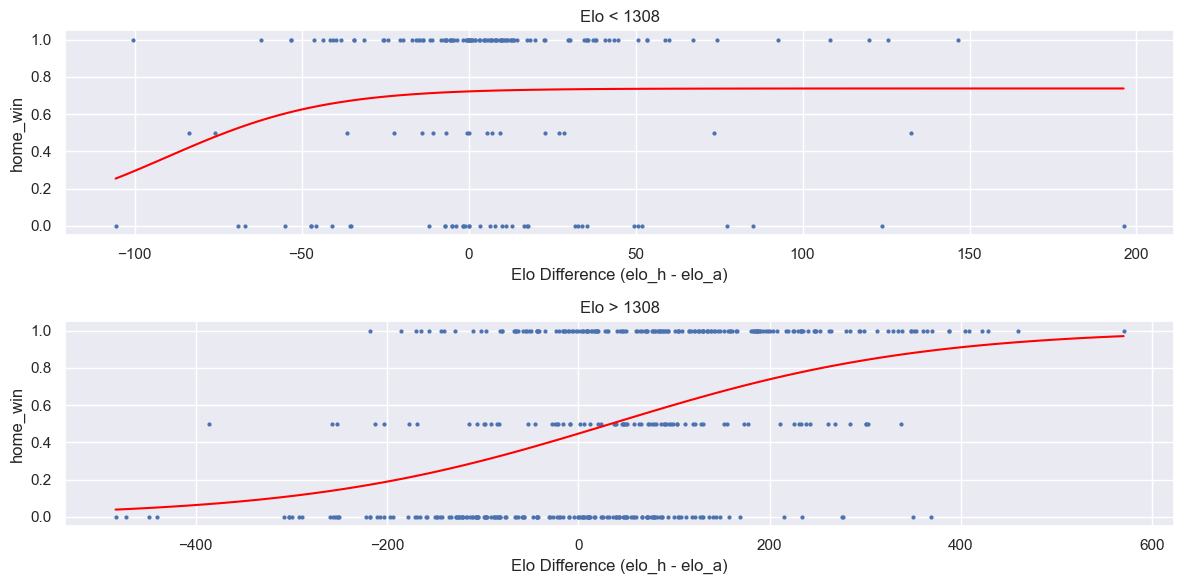

In [39]:
plot_high_low_elo(df_1999_new, 1308)

In [40]:
elo_1999_2011 = {}
df_add_elo(df_1999_2011, elo_1999_2011)

df_1999_2011['elo_diff'] = df_1999_2011['elo_h'] - df_1999_2011['elo_a']
add_expereience(df_1999_2011)

df_1999_2011_new = df_1999_2011.dropna()
df_1999_2011_new['home_win'] = df_1999_2011_new['home_win'].astype('category')
df_1999_2011_new.describe()

,date_Y,home_score,away_score,elo_h,elo_a,elo_diff,home_experience,away_experience
count,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000
mean,2006.156170,2.173522,1.427378,1394.713548,1339.086967,55.626581,27.901028,24.728792
std,3.380581,2.422981,1.912355,102.528536,97.018313,122.350901,27.444381,25.552613
min,2000.000000,0.000000,0.000000,1147.320000,1097.940000,-404.025000,1.000000,1.000000
25%,2003.000000,0.000000,0.000000,1319.606250,1290.927500,-5.477500,7.000000,6.000000
50%,2006.000000,2.000000,1.000000,1384.375000,1308.555000,54.725000,18.000000,15.000000
75%,2009.000000,3.000000,2.000000,1446.907500,1372.431250,112.236250,39.000000,34.000000
max,2011.000000,24.000000,24.000000,1879.745000,1748.965000,650.335000,121.000000,124.000000


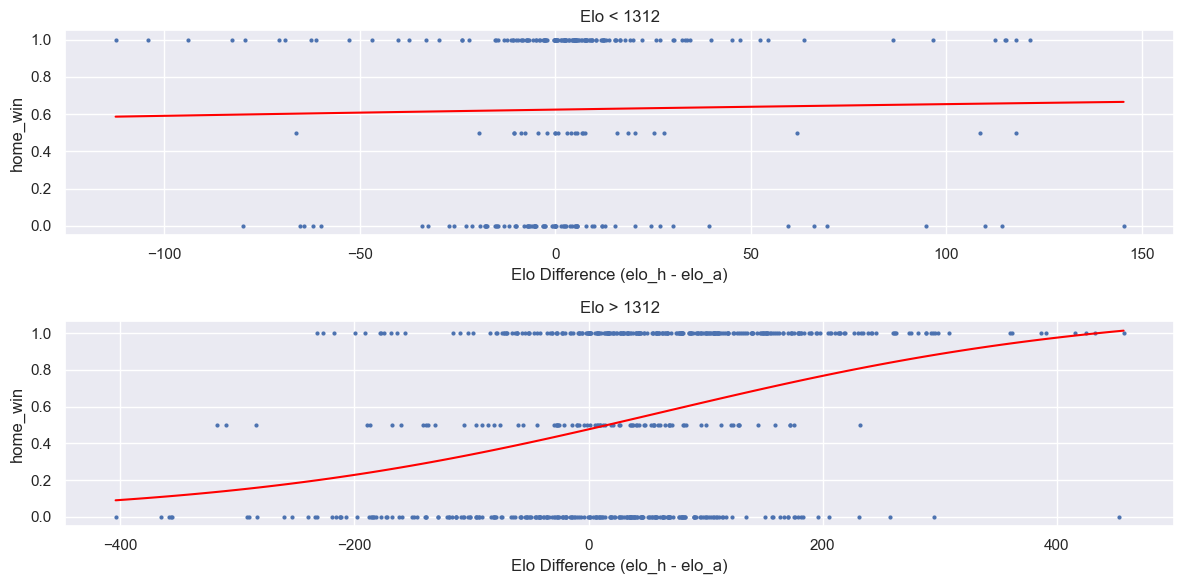

In [41]:
plot_high_low_elo(df_1999_2011_new, 1312)

In [42]:
elo_2011_2019 = {}
df_add_elo(df_2011_2019, elo_2011_2019)

df_2011_2019['elo_diff'] = df_2011_2019['elo_h'] - df_2011_2019['elo_a']
add_expereience(df_2011_2019)

df_2011_2019_new = df_2011_2019.dropna()
df_2011_2019_new['home_win'] = df_2011_2019_new['home_win'].astype('category')
df_2011_2019_new.describe()

,date_Y,home_score,away_score,elo_h,elo_a,elo_diff,home_experience,away_experience
count,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000
mean,2015.944789,1.969603,1.429901,1398.725065,1330.679414,68.045651,29.040323,23.640819
std,2.239824,2.283385,1.883161,115.951486,90.369811,138.739338,31.445245,22.142239
min,2012.000000,0.000000,0.000000,1083.720000,1055.840000,-426.450000,1.000000,1.000000
25%,2014.000000,0.000000,0.000000,1308.421250,1287.286250,-8.398750,7.000000,7.000000
50%,2016.000000,1.000000,1.000000,1383.810000,1305.937500,54.930000,19.000000,17.000000
75%,2018.000000,3.000000,2.000000,1448.656250,1367.272500,128.868750,40.000000,36.000000
max,2019.000000,21.000000,13.000000,1870.215000,1716.095000,611.470000,183.000000,175.000000


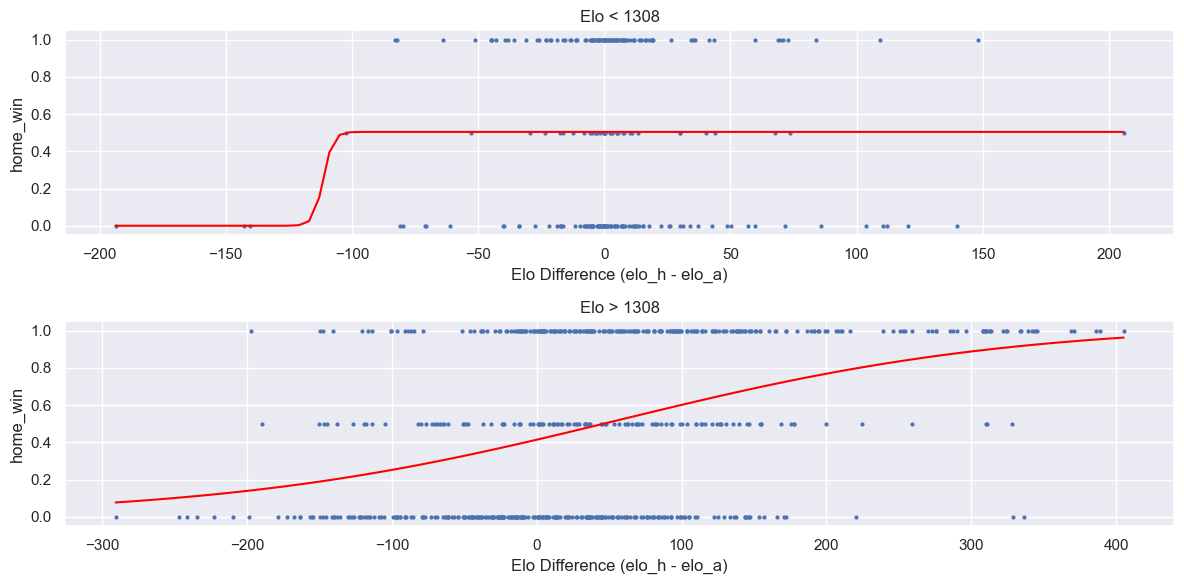

In [43]:
plot_high_low_elo(df_2011_2019_new, 1308)

- all three plot groups show that the relation between elo_diff and game result has different patterns in high elo and low elo games, therefore the model will use both teams' elo as two features, instead of elo_diff as one feature

In [44]:
#also process df_1999_2019 and df_2007_2019 for modeling later
elo_1999_2019 = {}
df_add_elo(df_1999_2019, elo_1999_2019)

df_1999_2019['elo_diff'] = df_1999_2019['elo_h'] - df_1999_2019['elo_a']
add_expereience(df_1999_2019)

df_1999_2019_new = df_1999_2019.dropna()
df_1999_2019_new['home_win'] = df_1999_2019_new['home_win'].astype('category')

In [45]:
elo_2007_2019 = {}
df_add_elo(df_2007_2019, elo_2007_2019)

df_2007_2019['elo_diff'] = df_2007_2019['elo_h'] - df_2007_2019['elo_a']
add_expereience(df_2007_2019)

df_2007_2019_new = df_2007_2019.dropna()
df_2007_2019_new['home_win'] = df_2007_2019_new['home_win'].astype('category')

- use statsmodels to check regression parameters

In [46]:
#create feaure: difference between experience
df_1999_new['experience_diff'] = df_1999_new['home_experience'] - df_1999_new['away_experience']
df_1999_2011_new['experience_diff'] = df_1999_2011_new['home_experience'] - df_1999_2011_new['away_experience']
df_2011_2019_new['experience_diff'] = df_2011_2019_new['home_experience'] - df_2011_2019_new['away_experience']
df_2007_2019_new['experience_diff'] = df_2007_2019_new['home_experience'] - df_2007_2019_new['away_experience']
df_1999_2019_new['experience_diff'] = df_1999_2019_new['home_experience'] - df_1999_2019_new['away_experience']

In [47]:
df_1999_X = df_1999_new[['elo_h','elo_a','experience_diff']]
df_1999_X = sm.add_constant(df_1999_X)
df_1999_Y = df_1999_new [['home_win']]
log_reg = sm.Logit(df_1999_Y, df_1999_X).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.554793
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.154     
Dependent Variable: home_win         AIC:              1199.6946 
Date:               2023-06-27 22:41 BIC:              1219.6111 
No. Observations:   1074             Log-Likelihood:   -595.85   
Df Model:           3                LL-Null:          -704.49   
Df Residuals:       1070             LLR p-value:      7.7671e-47
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.9757   0.8800  1.1088 0.2675 -0.7491  2.7005
elo_h              0.0045   0.0006  7.1117 0.0000  0.0033  0.0058


In [48]:
df_1999_2011_X = df_1999_2011_new[['elo_h','elo_a','experience_diff']]
df_1999_2011_X = sm.add_constant(df_1999_2011_X)
df_1999_2011_Y = df_1999_2011_new [['home_win']]
log_reg = sm.Logit(df_1999_2011_Y, df_1999_2011_X).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.597147
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.112     
Dependent Variable: home_win         AIC:              1866.3225 
Date:               2023-06-27 22:41 BIC:              1887.7220 
No. Observations:   1556             Log-Likelihood:   -929.16   
Df Model:           3                LL-Null:          -1046.1   
Df Residuals:       1552             LLR p-value:      2.0705e-50
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.9928   1.0116  0.9814 0.3264 -0.9899  2.9755
elo_h              0.0041   0.0007  5.9175 0.0000  0.0027  0.0055


In [49]:
df_2011_2019_X = df_2011_2019_new[['elo_h','elo_a','experience_diff']]
df_2011_2019_X = sm.add_constant(df_2011_2019_X)
df_2011_2019_Y = df_2011_2019_new [['home_win']]
log_reg = sm.Logit(df_2011_2019_Y, df_2011_2019_X).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.542563
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.206     
Dependent Variable: home_win         AIC:              1757.2228 
Date:               2023-06-27 22:41 BIC:              1778.7637 
No. Observations:   1612             Log-Likelihood:   -874.61   
Df Model:           3                LL-Null:          -1101.0   
Df Residuals:       1608             LLR p-value:      7.9433e-98
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              1.7446   1.1733  1.4869 0.1370 -0.5550  4.0443
elo_h              0.0049   0.0007  6.5959 0.0000  0.0034  0.0063


In [50]:
#check the regression result without the third feature
df_2011_2019_X = df_2011_2019_new[['elo_h','elo_a']]
df_2011_2019_X = sm.add_constant(df_2011_2019_X)
df_2011_2019_Y = df_2011_2019_new [['home_win']]
log_reg = sm.Logit(df_2011_2019_Y, df_2011_2019_X).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.574938
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.158     
Dependent Variable: home_win         AIC:              1859.6001 
Date:               2023-06-27 22:41 BIC:              1875.7558 
No. Observations:   1612             Log-Likelihood:   -926.80   
Df Model:           2                LL-Null:          -1101.0   
Df Residuals:       1609             LLR p-value:      2.1597e-76
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     0.9916     1.0294     0.9633   0.3354   -1.0260    3.0093
elo_h     0.0077     0.0006    12.3593   0.0000    0.0065 

In [51]:
df_1999_2019_X = df_1999_2019_new[['elo_h','elo_a','experience_diff']]
df_1999_2019_X = sm.add_constant(df_1999_2019_X)
df_1999_2019_Y = df_1999_2019_new [['home_win']]
log_reg = sm.Logit(df_1999_2019_Y, df_1999_2019_X).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.556597
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.179      
Dependent Variable: home_win         AIC:              3631.4461  
Date:               2023-06-27 22:41 BIC:              3655.7979  
No. Observations:   3255             Log-Likelihood:   -1811.7    
Df Model:           3                LL-Null:          -2206.1    
Df Residuals:       3251             LLR p-value:      1.2289e-170
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              0.7491   0.5157   1.4527 0.1463 -0.2616  1.7598
elo_h              0.0043   0.0004  11.1190 0.0000  0

### 4. Test LogisticRegression, RandomForestClassifier, and KNeighborsClassifier on dataset combos

In [52]:
def split_train_test_1(df, year):
    '''split dataset so that the latest world cup games are the test set, all other games are training set'''
    
    test_df = df[(df['date_Y'] == year) & (df['tournament'] == 'FIFA World Cup')]
    train_df = df[~((df['date_Y'] == year) & (df['tournament'] == 'FIFA World Cup'))]
    
    #remapping to avoid label error
    label_mapping = {0: 'lose', 0.5: 'tie', 1: 'win'}
    
    #create training set with three features
    X_train = train_df[['elo_h','elo_a','experience_diff']]
    y_train = train_df['home_win'].map(label_mapping)
    X_test = test_df[['elo_h','elo_a','experience_diff']]
    y_test = test_df['home_win'].map(label_mapping)
    
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
 
    return X_train, X_test, y_train, y_test

In [53]:
def split_train_test_2(df, year):
    '''split dataset so that the latest world cup games are the test set, all other games are training set
    Args: 
        df(variable): dataset to be split
        year(int): the year of the latest world cup in the dataset
    '''
    
    test_df = df[(df['date_Y'] == year) & (df['tournament'] == 'FIFA World Cup')]
    train_df = df[~((df['date_Y'] == year) & (df['tournament'] == 'FIFA World Cup'))]
    
    label_mapping = {0: 'lose', 0.5: 'tie', 1: 'win'}
    
    #create training set with two features
    X_train = train_df[['elo_h','elo_a']]
    y_train = train_df['home_win'].map(label_mapping)
    X_test = test_df[['elo_h','elo_a']]
    y_test = test_df['home_win'].map(label_mapping)
    
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
 
    return X_train, X_test, y_train, y_test

In [54]:
def metrics_display(model):
    '''display model performence metrics'''
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    fig, ax = plt.subplots(figsize=(3, 3))  
    disp.plot(ax=ax)  
    plt.show()  

- Train on games before 2000 to predict World Cup 1999

In [55]:
X_train, X_test, y_train, y_test = split_train_test_1(df_1999_new, 1999)

In [56]:
y_train.value_counts()

win     575
lose    318
tie     149
Name: home_win, dtype: int64

In [58]:
# Logistic Regression pipeline
lr_pipeline = Pipeline([('lr', LogisticRegression())])

# Random Forest pipeline
rf_pipeline = Pipeline([('rf', RandomForestClassifier())])

# K-Nearest Neighbors pipeline
knn_pipeline = Pipeline([('knn', KNeighborsClassifier())])

# List of pipelines
pipelines = [lr_pipeline, rf_pipeline, knn_pipeline]

In [59]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.62
RandomForestClassifier Accuracy: 0.59
KNeighborsClassifier Accuracy: 0.59


              precision    recall  f1-score   support

        lose       0.38      0.71      0.50         7
         tie       0.50      0.17      0.25         6
         win       0.76      0.68      0.72        19

    accuracy                           0.59        32
   macro avg       0.55      0.52      0.49        32
weighted avg       0.63      0.59      0.59        32



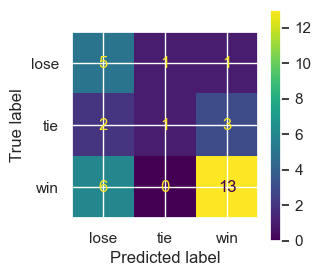

In [60]:
metrics_display(KNeighborsClassifier())

- Train on games between 2000 and 2012 to predict World Cup 2011

In [61]:
X_train, X_test, y_train, y_test = split_train_test_1(df_1999_2011_new, 2011)

In [62]:
y_train.value_counts()

win     806
lose    519
tie     199
Name: home_win, dtype: int64

In [63]:
oversampler = RandomOverSampler(sampling_strategy={'tie':500}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [64]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.62
RandomForestClassifier Accuracy: 0.59
KNeighborsClassifier Accuracy: 0.50


              precision    recall  f1-score   support

        lose       0.47      0.78      0.58         9
         tie       0.00      0.00      0.00         6
         win       0.76      0.76      0.76        17

    accuracy                           0.62        32
   macro avg       0.41      0.51      0.45        32
weighted avg       0.54      0.62      0.57        32



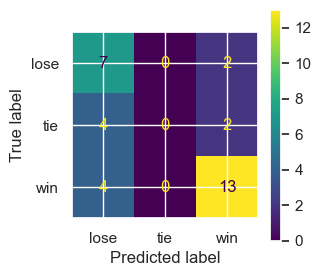

In [65]:
metrics_display(LogisticRegression())

- Train on games between 2012 and 2020 to predict World Cup 2019

In [66]:
X_train, X_test, y_train, y_test = split_train_test_1(df_2011_2019_new, 2019)

In [67]:
y_train.value_counts()

win     754
lose    554
tie     252
Name: home_win, dtype: int64

In [68]:
y_test.value_counts()

win     29
lose    19
tie      4
Name: home_win, dtype: int64

In [69]:
#oversample training data with label 'tie'
oversampler = RandomOverSampler(sampling_strategy={'tie':500}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [70]:
#oversample test data with label 'tie'
#oversampler = SMOTE(sampling_strategy='auto', k_neighbors=3)
#X_test, y_test = oversampler.fit_resample(X_test, y_test)

In [71]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.73
RandomForestClassifier Accuracy: 0.77
KNeighborsClassifier Accuracy: 0.69


              precision    recall  f1-score   support

        lose       0.65      0.79      0.71        19
         tie       1.00      0.25      0.40         4
         win       0.79      0.76      0.77        29

    accuracy                           0.73        52
   macro avg       0.81      0.60      0.63        52
weighted avg       0.75      0.73      0.72        52



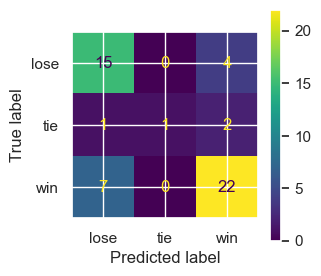

In [72]:
metrics_display(LogisticRegression())

In [73]:
#Look into prediction details
test_df = df_2011_2019_new[(df_2011_2019_new['date_Y'] == 2019) & (df_2011_2019_new['tournament'] == 'FIFA World Cup')]
X_train, X_test, y_train, y_test = split_train_test_1(df_2011_2019_new, 2019)
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
col_list =['home_team', 'away_team', 'home_score', 'away_score', 'elo_h', 'elo_a', 'elo_diff','experience_diff']
results_df = pd.concat([test_df[col_list], results_df], axis = 1)
results_df.sort_values(by = 'elo_diff', ascending = False)

,home_team,away_team,home_score,away_score,elo_h,elo_a,elo_diff,experience_diff,Actual,Predicted
1604,United States,Chile,3,0,1627.595,1279.910,347.685,161,win,win
1620,England,Cameroon,3,0,1680.550,1338.940,341.610,31,win,win
1600,England,Argentina,1,0,1644.010,1330.720,313.290,54,win,win
1592,United States,Thailand,13,0,1613.555,1304.035,309.520,142,win,win
1581,France,South Korea,4,0,1642.630,1334.090,308.540,0,win,win
1621,France,Brazil,2,1,1696.870,1400.745,296.125,16,win,win
1605,France,Nigeria,1,0,1681.150,1410.780,270.370,23,win,win
1584,Spain,South Africa,3,1,1525.960,1268.195,257.765,-9,win,win
1618,Germany,Nigeria,3,0,1646.100,1395.060,251.040,36,win,win
1603,Sweden,Thailand,5,1,1499.350,1289.995,209.355,39,win,win


In [74]:
#try the model with only two features
X_train, X_test, y_train, y_test = split_train_test_2(df_2011_2019_new, 2019)

In [75]:
oversampler = RandomOverSampler(sampling_strategy={'tie':500}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [76]:
#oversampler = SMOTE(sampling_strategy='auto', k_neighbors=3)
#X_test, y_test = oversampler.fit_resample(X_test, y_test)

In [77]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.79
RandomForestClassifier Accuracy: 0.58
KNeighborsClassifier Accuracy: 0.60


              precision    recall  f1-score   support

        lose       0.73      0.84      0.78        19
         tie       0.00      0.00      0.00         4
         win       0.83      0.86      0.85        29

    accuracy                           0.79        52
   macro avg       0.52      0.57      0.54        52
weighted avg       0.73      0.79      0.76        52



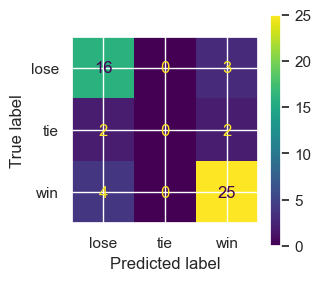

In [78]:
metrics_display(LogisticRegression())

In [79]:
#Look into prediction details of model2
X_train, X_test, y_train, y_test = split_train_test_2(df_2011_2019_new, 2019)
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df = pd.concat([test_df[col_list], results_df], axis = 1)
results_df.sort_values(by = 'elo_diff', ascending = False)

,home_team,away_team,home_score,away_score,elo_h,elo_a,elo_diff,experience_diff,Actual,Predicted
1604,United States,Chile,3,0,1627.595,1279.910,347.685,161,win,win
1620,England,Cameroon,3,0,1680.550,1338.940,341.610,31,win,win
1600,England,Argentina,1,0,1644.010,1330.720,313.290,54,win,win
1592,United States,Thailand,13,0,1613.555,1304.035,309.520,142,win,win
1581,France,South Korea,4,0,1642.630,1334.090,308.540,0,win,win
1621,France,Brazil,2,1,1696.870,1400.745,296.125,16,win,win
1605,France,Nigeria,1,0,1681.150,1410.780,270.370,23,win,win
1584,Spain,South Africa,3,1,1525.960,1268.195,257.765,-9,win,win
1618,Germany,Nigeria,3,0,1646.100,1395.060,251.040,36,win,win
1603,Sweden,Thailand,5,1,1499.350,1289.995,209.355,39,win,win


- Train on games between 2000 and 2020 to predict World Cup 2019

In [80]:
X_train, X_test, y_train, y_test = split_train_test_1(df_1999_2019_new, 2019)

In [81]:
y_train.value_counts()

win     1628
lose    1111
tie      464
Name: home_win, dtype: int64

In [82]:
y_test.value_counts()

win     29
lose    19
tie      4
Name: home_win, dtype: int64

In [83]:
oversampler = RandomOverSampler(sampling_strategy={'tie':1000}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [84]:
#oversampler = SMOTE(sampling_strategy='auto', k_neighbors=3)
#X_test, y_test = oversampler.fit_resample(X_test, y_test)

In [85]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.75
RandomForestClassifier Accuracy: 0.60
KNeighborsClassifier Accuracy: 0.54


              precision    recall  f1-score   support

        lose       0.59      0.53      0.56        19
         tie       0.11      0.25      0.15         4
         win       0.69      0.62      0.65        29

    accuracy                           0.56        52
   macro avg       0.46      0.47      0.45        52
weighted avg       0.61      0.56      0.58        52



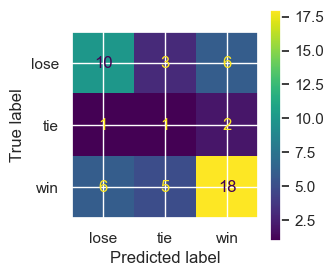

In [86]:
metrics_display(RandomForestClassifier())

In [87]:
X_train, X_test, y_train, y_test = split_train_test_2(df_1999_2019_new, 2019)

In [88]:
oversampler = RandomOverSampler(sampling_strategy={'tie':1000}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [89]:
#oversampler = SMOTE(sampling_strategy='auto', k_neighbors=3)
#X_test, y_test = oversampler.fit_resample(X_test, y_test)

In [90]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.81
RandomForestClassifier Accuracy: 0.58
KNeighborsClassifier Accuracy: 0.46


              precision    recall  f1-score   support

        lose       0.76      0.84      0.80        19
         tie       0.00      0.00      0.00         4
         win       0.84      0.90      0.87        29

    accuracy                           0.81        52
   macro avg       0.53      0.58      0.56        52
weighted avg       0.75      0.81      0.78        52



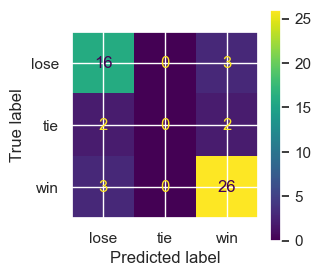

In [91]:
metrics_display(LogisticRegression())

- Train on games between 2008 and 2020 to predict World Cup 2019

In [92]:
X_train, X_test, y_train, y_test = split_train_test_1(df_2007_2019_new, 2019)

In [93]:
y_train.value_counts()

win     1075
lose     789
tie      326
Name: home_win, dtype: int64

In [94]:
y_test.value_counts()

win     29
lose    19
tie      4
Name: home_win, dtype: int64

In [95]:
oversampler = RandomOverSampler(sampling_strategy={'lose':1000, 'tie':500}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [96]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.71
RandomForestClassifier Accuracy: 0.67
KNeighborsClassifier Accuracy: 0.69


              precision    recall  f1-score   support

        lose       0.65      0.79      0.71        19
         tie       0.00      0.00      0.00         4
         win       0.76      0.76      0.76        29

    accuracy                           0.71        52
   macro avg       0.47      0.52      0.49        52
weighted avg       0.66      0.71      0.68        52



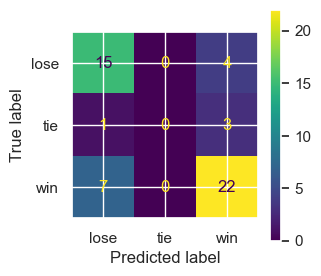

In [97]:
metrics_display(LogisticRegression())

In [98]:
X_train, X_test, y_train, y_test = split_train_test_2(df_2007_2019_new, 2019)

In [99]:
oversampler = RandomOverSampler(sampling_strategy={'lose':1000, 'tie':500}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [100]:
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'{model_name} Accuracy: {accuracy:.2f}')

LogisticRegression Accuracy: 0.77
RandomForestClassifier Accuracy: 0.71
KNeighborsClassifier Accuracy: 0.65


              precision    recall  f1-score   support

        lose       0.70      0.84      0.76        19
         tie       0.00      0.00      0.00         4
         win       0.83      0.83      0.83        29

    accuracy                           0.77        52
   macro avg       0.51      0.56      0.53        52
weighted avg       0.72      0.77      0.74        52



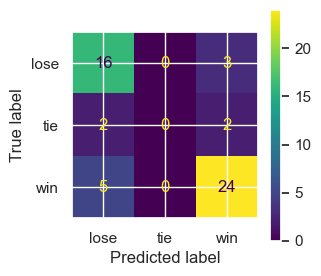

In [101]:
metrics_display(LogisticRegression())

### 5. bulid the final model and predict

- after review the performance metrics on multiple subset & model combos, I decided to apply logistic regression model with two features on data between 2010 and 2022

In [102]:
final_df = results_new[results_new['date_Y'] > 2010].reset_index(drop = True)

In [103]:
final_df.shape

(2226, 7)

In [104]:
final_df.head()

,date_Y,home_team,away_team,home_score,away_score,tournament,neutral
0,2011,Sweden,United States,2,1,Four Nations Tournament,True
1,2011,China PR,Canada,2,3,Four Nations Tournament,False
2,2011,China PR,Sweden,2,1,Four Nations Tournament,False
3,2011,United States,Canada,2,1,Four Nations Tournament,True
4,2011,Canada,Sweden,1,0,Four Nations Tournament,True


In [105]:
elo_final = {}
df_add_elo(final_df, elo_final)

add_expereience(final_df)

final_df_new = final_df.dropna()
final_df_new['home_win'] = final_df_new['home_win'].astype('category')
final_df_new['experience_diff'] = final_df_new['home_experience'] - final_df_new['away_experience']
final_df_new.describe()

,date_Y,home_score,away_score,elo_h,elo_a,home_experience,away_experience,experience_diff
count,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000
mean,2016.254780,1.977055,1.434034,1414.247741,1340.445672,35.306405,29.378585,5.927820
std,3.042124,2.322297,1.887042,141.068841,116.657535,36.869012,27.146169,34.254764
min,2011.000000,0.000000,0.000000,1001.320000,971.520000,1.000000,1.000000,-132.000000
25%,2014.000000,0.000000,0.000000,1305.748750,1276.350000,9.000000,8.000000,-7.000000
50%,2017.000000,1.000000,1.000000,1395.070000,1305.085000,24.000000,22.000000,1.000000
75%,2018.000000,3.000000,2.000000,1480.641250,1402.375000,50.000000,45.000000,13.000000
max,2022.000000,21.000000,13.000000,1916.840000,1814.860000,215.000000,212.000000,197.000000


In [106]:
final_df_new['home_win'].value_counts()

1.0    1024
0.0     743
0.5     325
Name: home_win, dtype: int64

In [107]:
#duplicate the data and swap home team with away team on each game to balance the sampled result
final_df_dup = pd.DataFrame()

In [108]:
final_df_dup['home_team'],final_df_dup['away_team'],final_df_dup['elo_h'],final_df_dup['elo_a'] = \
    final_df_new['away_team'],final_df_new['home_team'],final_df_new['elo_a'],final_df_new['elo_h'] 

In [109]:
final_df_dup['experience_diff'] = final_df_new['experience_diff'].apply(lambda x: x*(-1))

In [110]:
final_df_dup['home_win'] = final_df_new['home_win'].map({0: 1, 0.5: 0.5, 1: 0})

In [111]:
columns = final_df_dup.columns

In [112]:
final_merge = pd.concat([final_df_new[columns], final_df_dup], axis = 0, ignore_index = True)

In [113]:
final_merge.shape

(4184, 6)

In [114]:
final_merge['home_win'].value_counts()

0.0    1767
1.0    1767
0.5     650
Name: home_win, dtype: int64

In [115]:
final_merge.head()

,home_team,away_team,elo_h,elo_a,experience_diff,home_win
0,China PR,Sweden,1397.025,1302.500,0,1.0
1,United States,Canada,1297.500,1302.975,0,1.0
2,Canada,Sweden,1300.450,1300.450,0,1.0
3,China PR,United States,1399.075,1300.025,0,0.0
4,Japan,Finland,1297.515,1297.500,0,1.0


In [116]:
label_mapping = {0: 'lose', 0.5: 'tie', 1: 'win'}

In [117]:
X_train = final_merge[['elo_h','elo_a']]
y_train = final_merge['home_win'].map(label_mapping)

In [118]:
oversampler = RandomOverSampler(sampling_strategy={'tie':1767}, random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [119]:
final_model= LogisticRegression()

In [120]:
final_model.fit(X_train, y_train)

LogisticRegression()

In [121]:
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [122]:
dict(sorted(elo_final.items(), key=lambda item: item[1], reverse=True))

{'United States': 1816.2549999999987,
 'Germany': 1718.875,
 'England': 1680.1799999999992,
 'Netherlands': 1677.2550000000008,
 'France': 1670.3250000000007,
 'Sweden': 1661.0499999999993,
 'Spain': 1587.2499999999995,
 'Norway': 1584.3249999999998,
 'Italy': 1566.4950000000013,
 'Iceland': 1546.7000000000003,
 'Belgium': 1538.4850000000013,
 'Denmark': 1534.425,
 'Japan': 1533.4250000000002,
 'Austria': 1513.1150000000005,
 'Switzerland': 1481.7749999999992,
 'Russia': 1456.7199999999996,
 'Australia': 1452.5400000000004,
 'China PR': 1440.0899999999992,
 'Brazil': 1437.7149999999997,
 'Finland': 1425.8499999999997,
 'Czech Republic': 1401.1300000000006,
 'Scotland': 1400.005,
 'Nigeria': 1382.6400000000008,
 'Wales': 1378.4850000000004,
 'Portugal': 1368.1199999999997,
 'Poland': 1361.26,
 'South Korea': 1354.7050000000002,
 'Ghana': 1353.17,
 'Canada': 1346.2250000000006,
 'Ukraine': 1334.6150000000005,
 'Cameroon': 1334.58,
 'Argentina': 1327.7399999999998,
 'Papua New Guinea': 13

In [123]:
def predict_win(home_team, away_team):
    home_elo = elo_final[home_team]
    away_elo = elo_final[away_team]
       
    X_predict = pd.DataFrame({'elo_h': home_elo, 'elo_a': away_elo}, index = [0])
    y_predict = final_model.predict(X_predict)
    return y_predict

In [124]:
qualified = {'Group A':['New Zealand', 'Norway', 'Philippines', 'Switzerland'], 
             'Group B':['Australia', 'Republic of Ireland', 'Nigeria', 'Canada'],
             'Group C':['Spain', 'Costa Rica', 'Zambia', 'Japan'],
             'Group D':['England', 'Haiti', 'Denmark', 'China PR'],
             'Group E':['United States', 'Vietnam', 'Netherlands', 'Portugal'], 
             'Group F':['France', 'Jamaica', 'Brazil', 'Panama'],
             'Group G':['Sweden', 'South Africa', 'Italy', 'Argentina'], 
             'Group H':['Germany', 'Morocco', 'Colombia', 'South Korea']}

In [125]:
#update elo score dictionary as the world cup host countries will have home advantage
elo_final['New Zealand'] = elo_final['New Zealand']+100
elo_final['Australia'] = elo_final['Australia']+100

- predict group stage

In [126]:
def predict_group(group):
    '''predict the match results of all match combination between teams in the group and count final points in this stage
    Arg: group(str)'''
    points = {}
    print('-----------------------')
    print(group)
    for team in qualified[group]:
        points[team] = 0
    for match in itertools.combinations(qualified[group], 2):
        prediction = predict_win(*match)
        print(str(match[0]+' vs '+str(match[1]+': '+str(prediction))))
        if prediction == 'win':
            points[match[0]] += 3
        elif prediction == 'tie':
            points[match[0]] += 1
            points[match[1]] += 1
        else:
            points[match[1]] += 3
    print(points)

In [127]:
for key in qualified.keys():
    predict_group(key)

-----------------------
Group A
New Zealand vs Norway: ['lose']
New Zealand vs Philippines: ['tie']
New Zealand vs Switzerland: ['lose']
Norway vs Philippines: ['win']
Norway vs Switzerland: ['win']
Philippines vs Switzerland: ['lose']
{'New Zealand': 1, 'Norway': 9, 'Philippines': 1, 'Switzerland': 6}
-----------------------
Group B
Australia vs Republic of Ireland: ['win']
Australia vs Nigeria: ['win']
Australia vs Canada: ['win']
Republic of Ireland vs Nigeria: ['lose']
Republic of Ireland vs Canada: ['lose']
Nigeria vs Canada: ['tie']
{'Australia': 9, 'Republic of Ireland': 0, 'Nigeria': 4, 'Canada': 4}
-----------------------
Group C
Spain vs Costa Rica: ['win']
Spain vs Zambia: ['win']
Spain vs Japan: ['win']
Costa Rica vs Zambia: ['tie']
Costa Rica vs Japan: ['lose']
Zambia vs Japan: ['lose']
{'Spain': 9, 'Costa Rica': 1, 'Zambia': 1, 'Japan': 6}
-----------------------
Group D
England vs Haiti: ['win']
England vs Denmark: ['win']
England vs China PR: ['win']
Haiti vs Denmark: [

- predict round 16

In [128]:
def predict_ko(team_a, team_b):
    prediction = predict_win(team_a, team_b)
    if prediction == 'win':
        print('winner: '+str(team_a))
    elif prediction == 'lose':
        print('winner: '+str(team_b))
    else: 
        print('tie')

In [129]:
#match 49
predict_ko('Norway', 'Japan')

tie


Notes: \
Norway 2023 Goal keeper: Cecilie Haustaker Fiskerstrand 5'8", Aurora Mikalsen  5'9", Guro Pettersen  5'8" \
Japan 2023 Goal keeper: Chika Hirao  5'8", Momoko Tanaka  5'6", Ayaka Yamashita  5'6"
                        
Norway won penalty against Australia in World Cup 2019 and advanced to Quarter-finals.

In [130]:
#match 50
predict_ko('Switzerland', 'Spain')

winner: Spain


In [131]:
#match 51
predict_ko('United States', 'Italy')

winner: United States


In [132]:
#match 52
predict_ko('Sweden', 'Netherlands')

tie


Notes: \
Netherlands 2023 Goal keeper: Lize Kop 5'8", Barbara Lorsheyd  5'8", Daphne Van Domselaar  5'9", Jacintha Weimar  5'10" \
Sweden 2023 Goal keeper: Tove Enblom  5'10", Jennifer Falk  5'7", Zecira Musovic  5'10" 
                        
Netherlands won against Sweden in World Cup 2019 and advanced to final.

In [133]:
#match 53
predict_ko('Australia', 'Denmark')

tie


Notes:
Australia 2023 Goal keeper: Mackenzie Arnold 5'11", Teagan Micah 5'9", Jada Mathyssen Whyman 5'6", Lydia Williams 5'8"
Denmark 2023 Goal keeper: Lene Christensen 5'6", Kathrine Ostergaard Larsen 5'11", Maja Bay Ostergaard 5'7", Freja Rosenkrans Thisgaard  6'0"

Australia advanced to Round 16 in World Cup 2019. Denmark wasn't qualified.

In [134]:
#match 54
predict_ko('England', 'Canada')

winner: England


In [135]:
#match 55
predict_ko('France', 'South Korea')

winner: France


In [136]:
#match 56
predict_ko('Germany', 'Brazil')

winner: Germany


- predict quarterfinals

In [136]:
#match 57
predict_ko('Norway', 'United States')

winner: United States


In [137]:
#match 58
predict_ko('Spain', 'Netherlands')

winner: Netherlands


In [138]:
#match 59
predict_ko('Australia', 'France')

winner: France


In [139]:
#match 60
predict_ko('England', 'Germany')

winner: Germany


- predict semifinal

In [140]:
#match 61
predict_ko('United States', 'Netherlands')

winner: United States


In [141]:
#match 62
predict_ko('France', 'Germany')

winner: Germany


- predict third place

In [142]:
#match 63
predict_ko('Netherlands', 'France')

winner: Netherlands


- prediction final

In [143]:
#match 63
predict_ko('United States', 'Germany')

winner: United States
